### Github Analyzer

This notebook should have been deployed in Watson Studio .. 
    **but** Watson Studio doesn't support interactive notebooks

Git Repos to be investigated:

* https://github.ibm.com/wiotp/monitoring-dashboard
* https://github.ibm.com/wiotp/analytics-service


In [231]:
import csv
import requests
import collections
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [232]:
# custom functions - install with pip install git+https://github.com/sedgewickmm18/mmfunctions
from mmfunctions import gitanalyzer

In [233]:
# Repos and credentials
params = {}
params['REPO'] = 'wiotp/monitoring-dashboard'
params['REPO2'] = 'wiotp/analytics-service'
params['REPO_ID'] = 566611
params['REPO2_ID'] = 211664
params['ZENHUB_WORKSPACE'] = '5cd44ce4baded506ba8ddd5f'
params['GITHUB_TOKEN'] = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
params['ZENHUB_TOKEN'] = '814960f27921de182e39873816e4a54be9cdbb5000baa92d054e773949c1681e5e637c3bd30b54ad'
params['TRAVIS_TOKEN'] = '7B8mnG99oqNcHJgKKXMYVQ'
params['BASE_URL'] = 'https://github.ibm.com'
gitanalyzer.process_all(params)


In [234]:
# upload stuff for later use to COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
put monitoring-defects.csv s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in

upload: 'monitoring-defects.csv' -> 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv'  [1 of 1]
 710626 of 710626   100% in    3s   183.22 kB/s  done


In [235]:
# get it back from COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --force --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
get s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv wiotp-monitoring-dashboard-defects.csv

download: 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv' -> 'wiotp-monitoring-dashboard-defects.csv'  [1 of 1]
 710626 of 710626   100% in    2s   280.34 kB/s  done


In [236]:
defects_df = pd.read_csv('./wiotp-monitoring-dashboard-defects.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df['Updated'] = pd.to_datetime(df['Updated'])
df['Closed'] = pd.to_datetime(df['Closed'])

# Strip off outdated stuff
df = df[df['Pipeline'] != 'To Be Closed']
df.head(1)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Milestone,Type,Component,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
978,Error when rendering time series graph when a ...,wiotp/monitoring-dashboard,2020-04-16 21:40:01,2020-04-17 14:10:24,NaT,scottsd,rsiva,open,April 2020 Sprint 14,Bug,Monitoring,0,2,2,NaN,NaN,New Issues,"['Sev 2', 'Squad: Monitoring', 'bug', 'ui']"


In [241]:
# Assign some risks random risks
df['Risk'] = np.random.choice([1,2,3], df['Risk'].values.shape[0], p=[0.2, 0.3, 0.5])
#df['Title'] = df['Title'][:5]
#df.head(5)

In [237]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout, Button, ToggleButton, Box, Dropdown
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output

#w = widgets.IntSlider()
#display(w)

In [238]:
df['Color'] = '#ffcc99'
#df[df['Type'] == 'Issue']['Color'] = '#ff9999'
#df[df['Type'] == 'Bug']['Color'] = '#66b3ff'
#df[df['Type'] == 'Epic']['Color'] = '#99ff99'

dfs = [df[df['Severity'] == 1], df[df['Severity'] == 2], df[df['Severity'] == 3], 
       df[df['Severity'] == 4], df]

# prepare data
cnt = []
labels = []
explode = []
colors = []

for dfs_el in dfs:
    cnt_el = dfs_el.groupby('Type')['Title'].count()
    labels.append(cnt_el.index)
    explode.append(np.zeros(cnt_el.size) + 0.02)
    #colors.append(cnt_el['Color'])
    cnt.append(cnt_el)
    
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='23%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
box = Box(children=[dropdown], layout=box_layout)
    
def f(severity):
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,6))
        for i in [0,1,2,3,4]:
            ax[i].pie(cnt[i], explode=explode[i], labels=labels[i], autopct='%1.1f%%',
                      shadow=True, startangle=90)
            if i < 4:
                ax[i].set_title('Monitoring issues by Type\n   Severity: ' + str(i + 1))
            else:
                ax[i].set_title('Monitoring issues by Type\n   All severities')
    else:
        fig1, ax1 = plt.subplots()
        ax1.pie(cnt[severity], explode=explode[severity], labels=labels[severity], autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        if severity < 4:
            ax1.set_title('Monitoring issues by Type\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues by Type\n   All severities')

ws = interactive_output(f, {'severity': dropdown});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

### Velocities

- Overall Velocity
- Defect Velocity (**implemented** - starting mid 2019)
- Customer satisfaction (**no data** not included as we have no data)
- Defect breakdown by severity (**no data** we have no severities in our defects)
- Value per sprint (**no data** value of epics or stories is not known)
- Percentage of test case coverage (**no data** - we do not track that)
- Customer Support Requests (**no data*)
- Trends (let's define what trends we need)
- NPS (**no data**)
- Build failures (need to get Travis data)
- Deployment failures (Jenkins ?)
- Technical Debts (**no data** we need a label)

In [239]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


dfv = df.copy()
# replace NaT with now
dfv['Closed'] = dfv['Closed'].fillna(pd.Timestamp.now())
#dfv = dfv[dfv['Status'] == 'closed']

dfv = dfv[dfv['Created'] > StartWith]
dfv['Age_in_weeks'] = dfv['Closed'] - dfv['Created'] + pd.Timestamp('2020-01-01')
dfv = dfv[['Severity', 'Status', 'Age_in_weeks']]

dfvs = [dfv[dfv['Severity'] == 1], dfv[dfv['Severity'] == 2], dfv[dfv['Severity'] == 3], 
       dfv[dfv['Severity'] == 4], dfv]

IMAX = 40
emptydf = pd.DataFrame(index=np.arange(1,IMAX),columns=['Severity', 'Status'])
emptydf['Severity'] = 0
emptydf['Status'] = 'open'

cntv = []
labelsv = []
xv = []
for dfs_el in dfvs:
    cnt_el = dfs_el.groupby(dfs_el['Age_in_weeks'].dt.week).count().drop(columns='Age_in_weeks')
    # print (cnt_el)
    imax = cnt_el.index.max()
    if np.isnan(imax):
        cnt_el = emptydf.copy()
    elif imax <= IMAX:
        # print (cnt_el)
        # print (emptydf)
        cnt_el = emptydf.copy().merge(cnt_el, how='outer', left_index = True, right_index=True)
        cnt_el['Severity'] = cnt_el['Severity_y'].fillna(cnt_el['Severity_x'])
    labelsv.append(cnt_el.index)
    xv.append(np.arange(1, cnt_el.size))
    cntv.append(cnt_el)
    
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='45%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
dropdown2 = Dropdown(
    options=[('Open', 0), ('Closed', 1), ('All',2)],
    value=1,
    description='Status:',
)
box = Box(children=[dropdown,dropdown2], layout=box_layout)

def f(severity, status):
    #df_vel = df_velocity.copy()
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,3))
        for i in [0,1,2,3,4]:
            ax[i].bar(cntv[i].index, cntv[i]['Severity'].values)
            if i < 4:
                ax[i].set_title('Monitoring issues aging\n   Severity: ' + str(i + 1))
            else:
                ax[i].set_title('Monitoring issues aging\n   All severities')
            ax[i].set_xlabel('Age in weeks')
    else:
        fig1, ax1 = plt.subplots(figsize=(7,3))
        ax1.bar(cntv[severity].index, cntv[severity]['Severity'].values)
        if severity < 4:
            ax1.set_title('Monitoring issues aging\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues aging\n   All severities')
        ax1.set_xlabel('Age in weeks')

ws = interactive_output(f, {'severity': dropdown, 'status': dropdown2});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

### Initiatives, Epics, Stories

- Epics per Initiatives
- Initiative completion by percentage
- Percentage of Epics completed
- Percentage of stories completed by sprint vs what was committed
- Defects per story
- End to end start to completion average

Text(0.5, 1.0, 'Open Epics by value and risk')

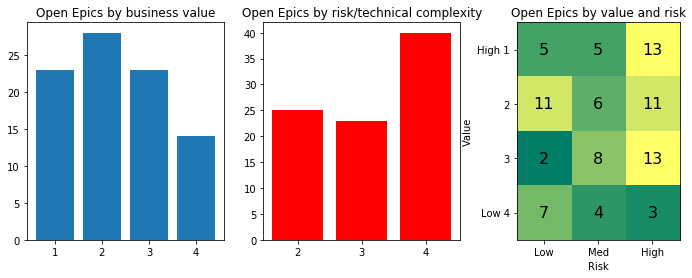

In [242]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_val = df.copy()
df_val = df_val[df_val['BusinessValue'] > 0]
df_val['Risk'] += 1
df_val = df_val[df_val['Status'] == 'open'][['BusinessValue','Risk', 'Title']]
fig, ax = plt.subplots(1, 3, figsize=(12,4))
val_el = df_val.groupby(df_val['BusinessValue']).count()
risk_el = df_val.groupby(df_val['Risk']).count()
valrisk_el = df_val.groupby(['BusinessValue','Risk']).size()
valrisk_grid = valrisk_el.unstack().to_numpy()
ax[0].bar(val_el.index, val_el['Title'].values)
ax[0].set_title('Open Epics by business value')

ax[1].bar(risk_el.index, risk_el['Title'].values, color='red')
ax[1].set_title('Open Epics by risk/technical complexity')

ax[2].imshow(valrisk_grid, interpolation ='none', cmap='summer')
for (j,i),label in np.ndenumerate(valrisk_grid):
    ax[2].text(i,j,label,ha='center',va='center',fontsize=16)

ax[2].set_xlabel('Risk')
ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['Low','Med','High'])
ax[2].set_ylabel('Value')
ax[2].set_yticks([0,1,2,3])
ax[2].set_yticklabels(['High 1',2,3,'Low 4'])
#ax[2].set_yticks([1,2,3,4,5])
ax[2].set_title('Open Epics by value and risk')


In [229]:
# Open vs closed epics

def f(date):
    df_epics = df[df['Type'] == 'Epic']   
    df_epics = df_epics[df_epics['Created'] > date]
    df_epics = df_epics[['Status', 'Type']]
    length = 20 * df_epics.index.size / 200
    df_epics.groupby(df_epics['Status']).count().plot(figsize=(length,2), kind='barh', legend=False)
    plt.title('Epics by completion \n created after ' + date)

interact(f, date=[('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-30'), ('Jan 2020', '2019-12-31'), 
                  ('Feb 2020','2020-01-31'), ('Mar 2020', '2020-02-28'), ('Apr 2020','2020-03-31')]);

interactive(children=(Dropdown(description='date', options=(('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-…